# Table of Contents
* [1. Introduction](#1-Introduction)

* [2. Libraries](#2-Libraries)

* [3. Examine](#3-Examine)
    * [3.1 Meta-data](#3.1-Meta-Data)
    * [3.2 Data overview](#3.2-Data-Overview)
        * [3.2.1 Train And Test Distribution](#3.2.1-Train-And-Test-Distribution)

* [4. EDA](#4-EDA)
    * [4.1 Data Normality](#4.1-Data-Normality)
    * [4.2 Linearity](#4.2-Linearity)
    * [4.3 Outliers](#4.3-Outliers)

* [5. Preprocessing pipeline](#5-Preprocessing-pipeline)

* [6. Modelling](#7-Modelling)
    * [6.1 Linear Model](#7.1-Linear-Model)
        * [6.1.1-Apply-Regularization](#7.1.1-Apply-Regularization)
    * [6.2 Polynomial model - Degree 3 (Overfitting)](#7.2-Polynomial-model---Degree-3-(Overfitting))

    * [6.3 Polynomial degree 2](#7.3-Polynomial-degree-2)
        * [6.3.1 Regularization of Polynomial degree 2](#7.3.1-Regularization-of-Polynomial-degree-2)
        * [6.3.2 Grid search for alpha](#7.3.2-Grid-search-for-alpha)

* [7. Summary](#7-Summary)
* [8. Test Predictions](#8-.-Test-Predictions)


# 1. Introduction

Machine learning, a subfield of artificial intelligence, involves developing algorithms that enable computers to learn from and make decisions based on data without explicit programming. This report focuses on a supervised learning problem where we aim to predict an individual's lifespan based on attributes associated with their birth region. Supervised learning uses labeled data to predict a labeled attribute, such as using linear regression to forecast a continuous numerical variable.

In our study, we employ the following key components:

- Dataset (Experience): Our primary source of learning, where the model identifies patterns.
- Model (Hypothesis Space): We use linear regression models, specifically focusing on Lasso regularization to handle feature selection implicitly.
- Cost Function (Loss): We utilize functions like mean squared error and the coefficient of determination to evaluate and minimize prediction errors.
- Optimization Procedure: Techniques such as gradient descent optimize the model by adjusting parameters to reduce the cost function.

Given constraints that restrict feature extraction, creation, and removal, our strategy emphasizes maximizing the effectiveness of Lasso regularization through careful data preprocessing. This is because Lasso apply feature selection. After conducting exploratory data analysis (EDA) to understand underlying patterns and characteristics, we'll process the data by managing missing values, outliers, and scaling features. This preparation aims to enhance Lasso's performance, enabling it to efficiently select relevant features and improve prediction accuracy.


Let's get started!

# 2. Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, FunctionTransformer, OneHotEncoder, PolynomialFeatures, QuantileTransformer
from scipy.stats import kstest

# Ignore specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

# Or, to ignore all FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Alternatively, to ignore all warnings (not recommended for general use)
warnings.filterwarnings('ignore')


# 3. Examine

In this section, we dive into our dataset to understand it better. We start by adding metadata for extra context and use the `.head()` method to look at the first few rows. This helps us see what our data looks like. Then, we check if the training and testing data are split properly since a good split is crucial for our model's success. We also use `.info()` to check for missing values and understand our data types. These steps give us a good overview and prepare us for the next steps of cleaning, exploratry data analysis and building our model.

## 3.1 Meta Data

- ID: row index (not an attribute)

- TARGET-LifeExpectancy: Life Expectancy in age (years)

- Country: index of Country

- Year: Year

- Status: Developed or Developing status (0, 1)

- AdultMortality: Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)

- AdultMortality-Female: Adult Mortality Rates of Female (probability of dying between 15 and 60 years per 1000 population)

- AdultMortality-Male: Adult Mortality Rates of Male (probability of dying between 15 and 60 years per 1000 population)

- SLS: Number of Short Life Span per 1000 population

- Alcohol: Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)

- PercentageExpenditure: Expenditure on health as a percentage of Gross Domestic Product per capita(%)

- Measles: Measles - number of reported cases per 1000 population

- BMI: Average: Body Mass Index of entire population

- Under5LS: Number of under-five Life Span per 1000 population

- Polio: Polio (Pol3) immunization coverage among 1-year-olds (%)

- TotalExpenditure: General government expenditure on health as a percentage of total government expenditure (%)

- Diphtheria: Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)

- HIV-AIDS: Factor indicating between 0-4 years life span per 1000 HIV/AIDS 

- GDP: Gross Domestic Product per capita (in USD)

- Population: Population of the country

- Thinness1-19years: Prevalence of thinness among children and adolescents for Age 10 to 19 (% )

- Thinness5-9years: Prevalence of thinness among children for Age 5 to 9(%)

- IncomeCompositionOfResources : Human Development Index in terms of income composition of resources (index ranging from 0 to 1)

- Schooling: Schooling indicator

## 3.2 Data Overview

In [2]:
# Reading the datasets
train = pd.read_csv('dataset/train.csv', index_col=0)
test = pd.read_csv('dataset/test.csv', index_col=0)

# Specify the size of the training set
train_size = 0.75  # 75% of the original training data (60% of the total data)

# Splitting the original training dataset into new training and validation sets
train, validation = train_test_split(train, train_size=train_size, shuffle=True, random_state=0)

# Print the sizes of the new splits to confirm the distribution
print("Training set size:", train.shape[0])
print("Validation set size:", validation.shape[0])
print("Test set size:", test.shape[0])

Training set size: 1553
Validation set size: 518
Test set size: 867


In [3]:
# for hyperparameter tuning
train_hyperparameter = train.copy()
validation_hyperparameter = validation.copy()

In [4]:
train.head(3)

,TARGET_LifeExpectancy,Country,Year,Status,AdultMortality,AdultMortality-Male,AdultMortality-Female,SLS,Alcohol,PercentageExpenditure,...,Polio,TotalExpenditure,Diphtheria,HIV-AIDS,GDP,Population,Thinness1-19years,Thinness5-9years,IncomeCompositionOfResources,Schooling
ID,,,,,,,,,,,,,,,,,,,,,
1960,80.9,62,2017,1,13,12,14,23,8.63,0.000000,...,93,15.60,95.0,0.1,413.73,127445,0.8,0.6,0.463,3.065942
995,60.8,59,2016,0,255,258,252,56,0.01,170.962662,...,93,5.72,92.0,2.9,1495.92,462425,7.8,7.7,0.546,3.331666
989,66.4,71,2006,0,287,272,302,8,6.55,33.916602,...,99,3.95,82.0,0.1,3219.20,1512985,2.5,2.6,0.725,3.674235


In [5]:
test.head(3)

,Country,Year,Status,AdultMortality,AdultMortality-Male,AdultMortality-Female,SLS,Alcohol,PercentageExpenditure,Measles,...,Polio,TotalExpenditure,Diphtheria,HIV-AIDS,GDP,Population,Thinness1-19years,Thinness5-9years,IncomeCompositionOfResources,Schooling
ID,,,,,,,,,,,,,,,,,,,,,
1,120,2017,0,335,314,356,66,6.35,0.000000,118,...,7.0,3.84,64,1.9,4139.29,2785935.0,8.3,8.2,0.531,3.376389
2,120,2016,0,348,338,358,67,8.33,23.965612,11699,...,68.0,3.31,64,2.0,536.83,2692466.0,8.5,8.3,0.527,3.376389
3,120,2015,0,355,362,348,69,8.10,35.958573,8523,...,67.0,4.26,77,2.3,542.77,2599834.0,8.6,8.5,0.523,3.376389


In [6]:
validation.head(3)

,TARGET_LifeExpectancy,Country,Year,Status,AdultMortality,AdultMortality-Male,AdultMortality-Female,SLS,Alcohol,PercentageExpenditure,...,Polio,TotalExpenditure,Diphtheria,HIV-AIDS,GDP,Population,Thinness1-19years,Thinness5-9years,IncomeCompositionOfResources,Schooling
ID,,,,,,,,,,,,,,,,,,,,,
1692,52.6,25,2012,0,359,380,338,27,0.49,0.000000,...,44,2.74,45.0,4.0,1749.71,167192,1.3,1.3,0.000,0.000000
1198,73.8,111,2005,0,112,108,116,0,1.75,491.497891,...,98,5.90,98.0,0.1,3844.12,34,14.6,14.7,0.601,3.435113
1095,56.6,26,2012,0,272,276,268,9,3.64,41.910524,...,71,11.87,7.0,1.8,366.72,3948125,7.4,7.2,0.403,3.098387


### 3.2.1 Train And Test Distribution

In machine learning, it's essential to divide data into training and testing sets. This division helps us build or select a hypothesis model that accurately captures the data's behavior, allowing us to evaluate the model's ability to generalize and avoid underfitting or overfitting.

Underfitting occurs when a model is too simple to capture the data's underlying patterns, resulting in poor performance on both the training data and unseen data, which are inherently more complex.

Overfitting happens when a model is too complex, closely fitting the training data, including noise and random fluctuations as if they were significant patterns. This leads to poor performance on new, unseen data, as the model fails to generalize beyond its training set.

Utilizing the `.describe()` method enables us to obtain a summary, encompassing the mean, standard deviations, and other statistics, for the attributes within both the training and testing datasets. Additionally, visualizing the distributions of these attributes can further confirm and complement the insights gained from this summary.

In [7]:
train.describe()

,TARGET_LifeExpectancy,Country,Year,Status,AdultMortality,AdultMortality-Male,AdultMortality-Female,SLS,Alcohol,PercentageExpenditure,...,Polio,TotalExpenditure,Diphtheria,HIV-AIDS,GDP,Population,Thinness1-19years,Thinness5-9years,IncomeCompositionOfResources,Schooling
count,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,...,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1.553000e+03,1553.000000,1553.000000,1553.000000,1553.000000
mean,69.067160,96.378622,2009.447521,0.179008,164.386993,163.452672,165.321314,33.891822,4.650180,764.319145,...,82.401803,5.822859,82.510625,1.600837,7276.725409,1.270170e+07,4.940953,4.970316,0.606346,3.360784
std,9.518896,55.263167,4.614939,0.383483,117.952322,118.338222,118.051602,132.157688,4.191486,2132.177796,...,23.449404,2.569081,23.282105,4.503864,15595.698398,6.457711e+07,4.667985,4.751173,0.216283,0.599059
min,37.300000,0.000000,2002.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.010000,0.000000,...,3.000000,0.370000,3.000000,0.100000,6.350000,4.100000e+01,0.100000,0.100000,0.000000,0.000000
25%,62.600000,50.000000,2005.000000,0.000000,76.000000,74.000000,76.000000,0.000000,0.590000,5.670640,...,76.000000,3.980000,78.000000,0.100000,413.730000,1.274450e+05,1.600000,1.500000,0.463000,3.065942
50%,70.800000,95.000000,2009.000000,0.000000,144.000000,144.000000,144.000000,3.000000,3.810000,64.605901,...,93.000000,5.600000,93.000000,0.100000,1358.070000,7.248170e+05,3.200000,3.300000,0.651000,3.449638
75%,75.800000,145.000000,2013.000000,0.000000,233.000000,234.000000,234.000000,22.000000,7.670000,400.134297,...,97.000000,7.340000,97.000000,0.900000,5306.190000,5.716152e+06,7.400000,7.400000,0.764000,3.728270
max,92.700000,192.000000,2017.000000,1.000000,682.000000,704.000000,660.000000,1800.000000,17.870000,19479.911610,...,99.000000,17.600000,99.000000,49.900000,133473.470000,1.179681e+09,27.700000,28.600000,0.945000,4.381780


In [8]:
test.describe()

,Country,Year,Status,AdultMortality,AdultMortality-Male,AdultMortality-Female,SLS,Alcohol,PercentageExpenditure,Measles,...,Polio,TotalExpenditure,Diphtheria,HIV-AIDS,GDP,Population,Thinness1-19years,Thinness5-9years,IncomeCompositionOfResources,Schooling
count,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,...,867.000000,867.000000,867.000000,867.000000,867.000000,8.670000e+02,867.000000,867.000000,867.000000,867.000000
mean,97.908881,2009.519031,0.147636,168.310265,167.351788,169.268743,23.673587,4.323230,675.455038,3193.158016,...,81.675894,5.926228,80.869666,2.002999,6768.605686,4.977211e+06,4.458247,4.474740,0.638852,3.444089
std,59.047382,4.615772,0.354943,136.148089,136.339678,136.521130,54.762901,3.624657,1742.603943,14422.950469,...,24.150902,2.287944,25.153943,5.716692,14405.688854,1.069932e+07,3.614439,3.704803,0.185802,0.538432
min,1.000000,2002.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.010000,0.000000,0.000000,...,3.000000,1.120000,3.000000,0.100000,4.130000,1.350000e+02,0.100000,0.100000,0.000000,0.000000
25%,41.000000,2006.000000,0.000000,71.000000,68.000000,72.000000,0.000000,1.155000,2.005443,0.000000,...,78.500000,4.325000,78.000000,0.100000,413.730000,1.274450e+05,1.400000,1.400000,0.483000,3.154352
50%,104.000000,2010.000000,0.000000,143.000000,140.000000,144.000000,2.000000,3.240000,60.341451,13.000000,...,92.000000,5.830000,91.000000,0.100000,1272.850000,3.331430e+05,3.500000,3.400000,0.677000,3.535534
75%,155.000000,2014.000000,0.000000,224.000000,223.000000,226.000000,23.500000,7.435000,466.703840,243.000000,...,97.000000,7.500000,97.000000,0.600000,4755.220000,3.253793e+06,6.800000,6.700000,0.778500,3.781534
max,191.000000,2017.000000,1.000000,723.000000,742.000000,778.000000,490.000000,13.200000,11734.853810,182485.000000,...,99.000000,11.790000,99.000000,43.500000,99192.600000,5.414673e+07,16.300000,19.100000,0.937000,4.549725


In [9]:
validation.describe()

,TARGET_LifeExpectancy,Country,Year,Status,AdultMortality,AdultMortality-Male,AdultMortality-Female,SLS,Alcohol,PercentageExpenditure,...,Polio,TotalExpenditure,Diphtheria,HIV-AIDS,GDP,Population,Thinness1-19years,Thinness5-9years,IncomeCompositionOfResources,Schooling
count,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,...,518.000000,518.000000,518.000000,518.000000,518.000000,5.180000e+02,518.000000,518.000000,518.000000,518.000000
mean,69.896139,92.306950,2009.731660,0.204633,158.177606,157.277992,159.077220,30.644788,4.834884,765.203002,...,83.702703,6.066737,83.480695,1.728958,7580.646390,1.004584e+07,4.942278,4.998263,0.619158,3.407439
std,9.353222,53.576356,4.609657,0.403823,121.584969,122.692473,121.011748,146.406899,4.249840,1925.183097,...,22.383255,2.505723,22.678448,5.537606,14045.278367,6.191813e+07,4.790760,4.891695,0.217202,0.564567
min,41.100000,0.000000,2002.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.010000,0.000000,...,3.000000,0.920000,2.000000,0.100000,1.880000,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,64.600000,48.000000,2006.000000,0.000000,72.250000,70.000000,74.000000,0.000000,0.962500,7.033380,...,79.000000,4.400000,79.000000,0.100000,413.730000,1.274450e+05,1.600000,1.600000,0.466000,3.118486
50%,72.000000,90.000000,2010.000000,0.000000,141.500000,140.000000,144.000000,2.000000,3.885000,78.950956,...,94.000000,5.820000,93.000000,0.100000,1559.640000,4.868720e+05,3.200000,3.300000,0.659500,3.478505
75%,76.475000,138.000000,2014.000000,0.000000,217.000000,214.000000,218.000000,20.000000,8.232500,522.893783,...,97.000000,7.775000,97.000000,0.600000,7060.155000,3.826081e+06,7.300000,7.375000,0.785750,3.754997
max,90.700000,192.000000,2017.000000,1.000000,699.000000,696.000000,722.000000,1800.000000,16.990000,18379.329740,...,99.000000,17.240000,99.000000,50.600000,98164.360000,1.293859e+09,27.500000,28.500000,0.948000,4.335897


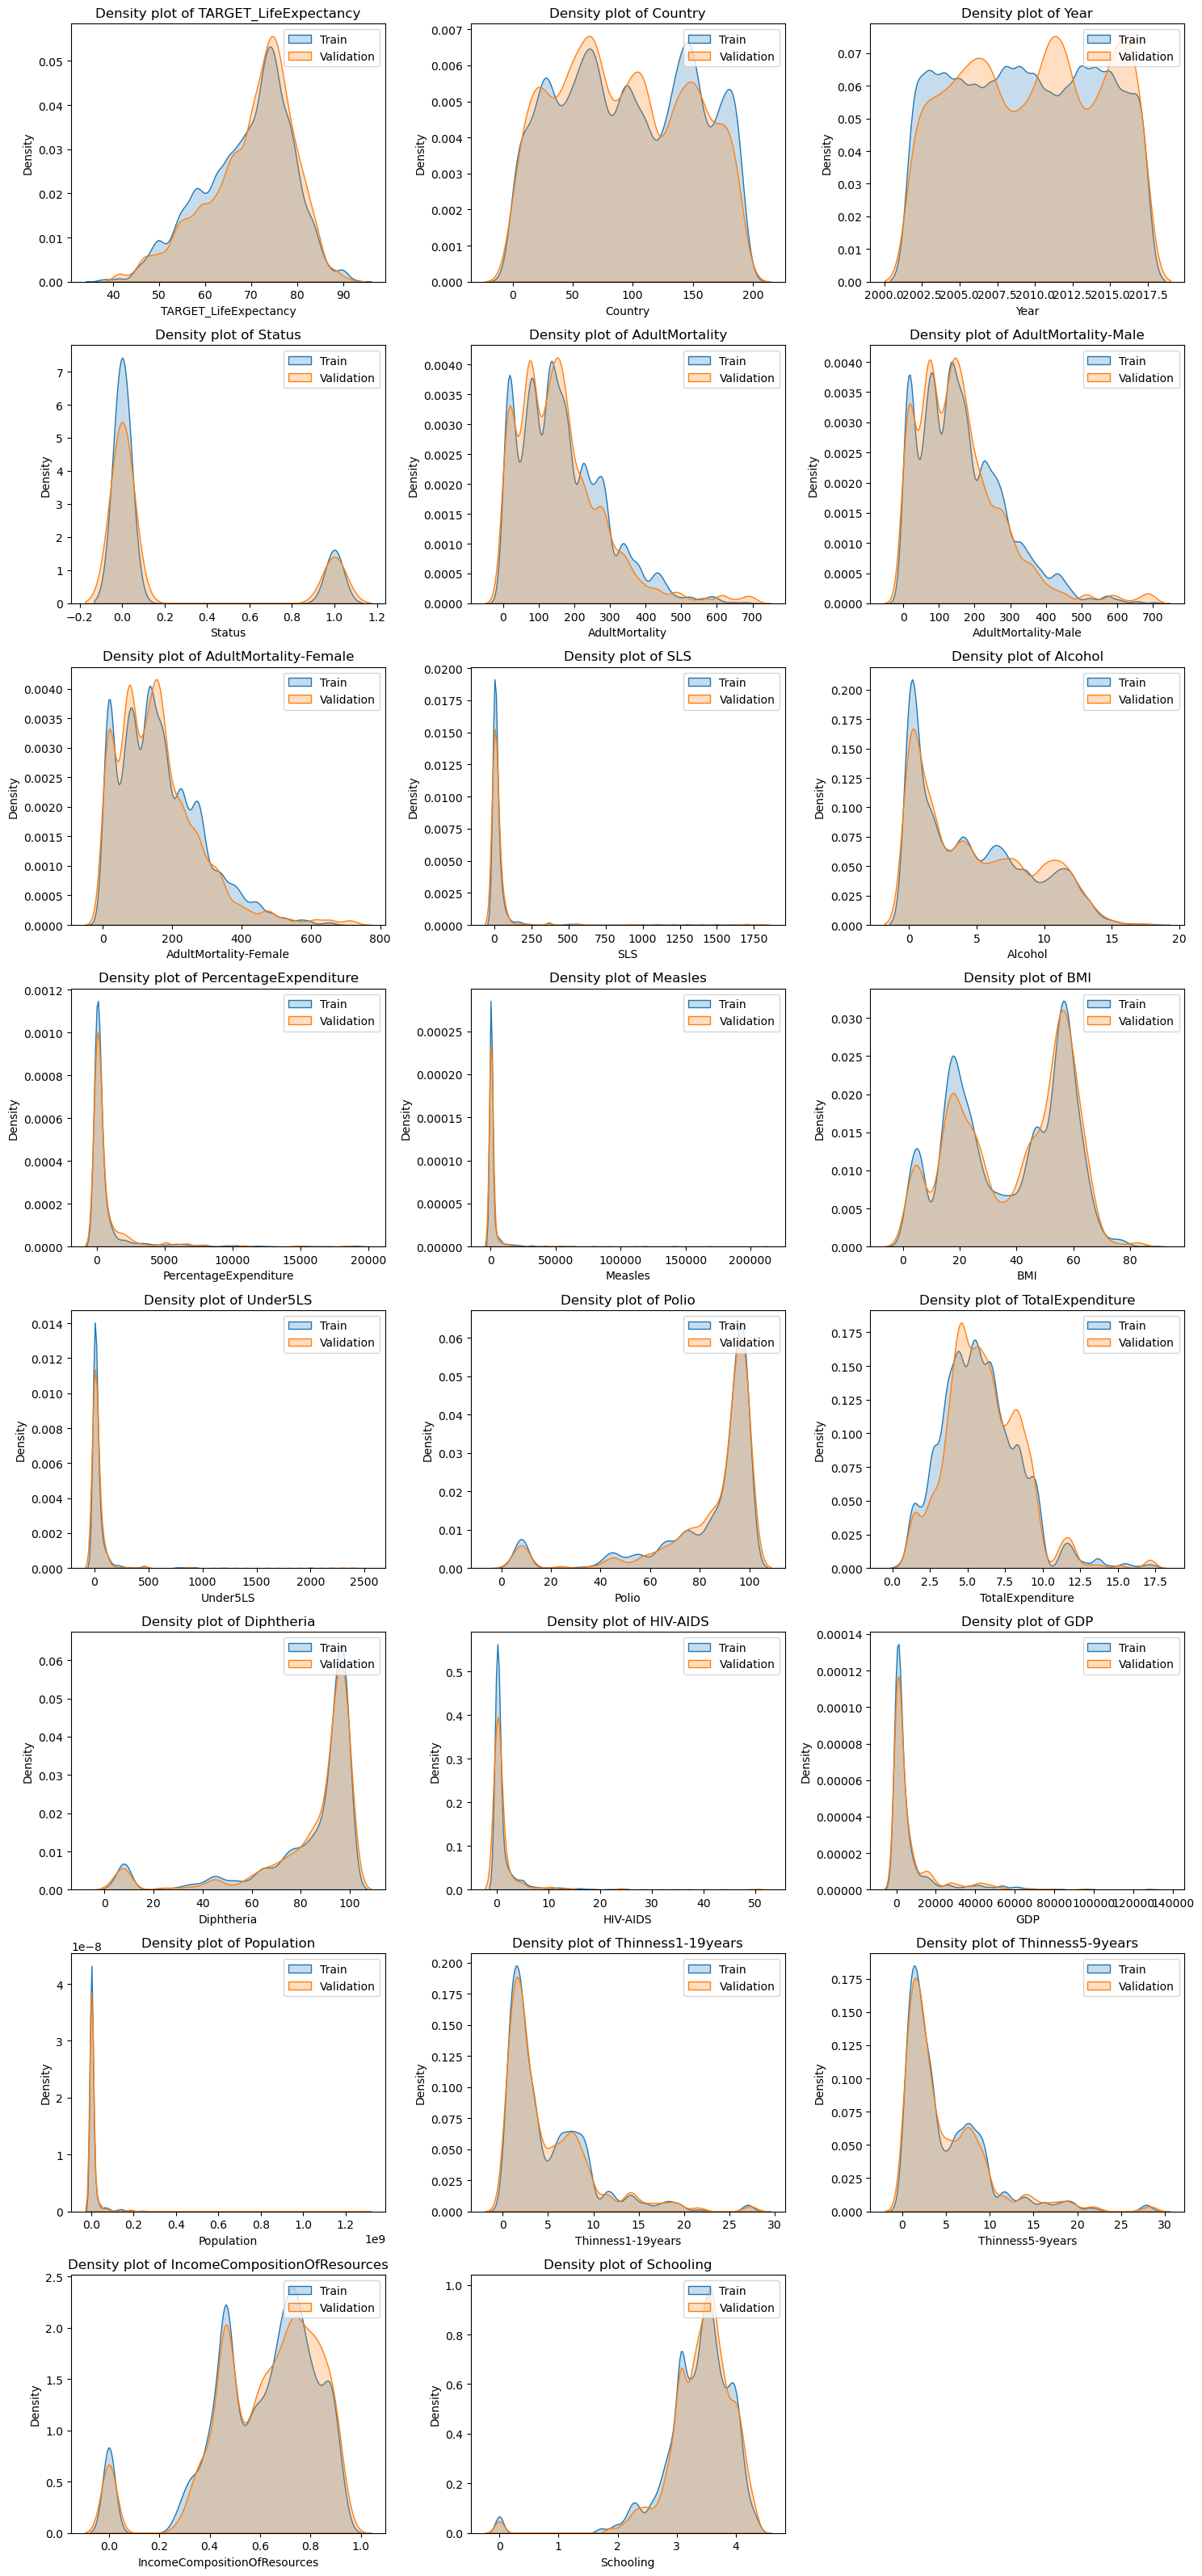

In [10]:
features = train.columns
numeric_features = [feature for feature in features if train[feature].dtype in ['float64', 'int64']]

# Determine the number of rows/columns based on the number of numeric features
n_cols = 3  # You can adjust this based on your preference or display width
n_rows = (len(numeric_features) + n_cols - 1) // n_cols  # Calculates the required number of rows

plt.figure(figsize=(n_cols * 5, n_rows * 4))  # Adjust the figure size as needed

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(train[feature], label='Train', fill=True, bw_adjust=0.5)
    sns.kdeplot(validation[feature], label='Validation', fill=True, bw_adjust=0.5)

    plt.title(f'Density plot of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()


> <span style="font-size:5em;">🔍</span> **Observations:**
> - The mean and standard deviations of attributes in all the training, testing and validation datasets exhibit close alignment. Visual confirmation through graphical representation is planned.
> - Graphical analysis affirms a well-executed split, showcasing uniform distribution across the training and testing sets.
> - Country, Year and Status attributes looks categorical from how their distributions looks like.


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1553 entries, 1960 to 1654
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TARGET_LifeExpectancy         1553 non-null   float64
 1   Country                       1553 non-null   int64  
 2   Year                          1553 non-null   int64  
 3   Status                        1553 non-null   int64  
 4   AdultMortality                1553 non-null   int64  
 5   AdultMortality-Male           1553 non-null   int64  
 6   AdultMortality-Female         1553 non-null   int64  
 7   SLS                           1553 non-null   int64  
 8   Alcohol                       1553 non-null   float64
 9   PercentageExpenditure         1553 non-null   float64
 10  Measles                       1553 non-null   int64  
 11  BMI                           1553 non-null   float64
 12  Under5LS                      1553 non-null   int64  
 13  Polio

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 867 entries, 1 to 867
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       867 non-null    int64  
 1   Year                          867 non-null    int64  
 2   Status                        867 non-null    int64  
 3   AdultMortality                867 non-null    int64  
 4   AdultMortality-Male           867 non-null    int64  
 5   AdultMortality-Female         867 non-null    int64  
 6   SLS                           867 non-null    int64  
 7   Alcohol                       867 non-null    float64
 8   PercentageExpenditure         867 non-null    float64
 9   Measles                       867 non-null    int64  
 10  BMI                           867 non-null    float64
 11  Under5LS                      867 non-null    int64  
 12  Polio                         867 non-null    float64
 13  TotalExpen

In [13]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518 entries, 1692 to 724
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TARGET_LifeExpectancy         518 non-null    float64
 1   Country                       518 non-null    int64  
 2   Year                          518 non-null    int64  
 3   Status                        518 non-null    int64  
 4   AdultMortality                518 non-null    int64  
 5   AdultMortality-Male           518 non-null    int64  
 6   AdultMortality-Female         518 non-null    int64  
 7   SLS                           518 non-null    int64  
 8   Alcohol                       518 non-null    float64
 9   PercentageExpenditure         518 non-null    float64
 10  Measles                       518 non-null    int64  
 11  BMI                           518 non-null    float64
 12  Under5LS                      518 non-null    int64  
 13  Polio  

> <span style="font-size:5em;">🔍</span> **Observations:**
> - All data types are integer and floats.
> - Country, Year, and Status, identified as categorical attributes, are represented as integers. In the upcoming section (2. Preparation), we will verify their correct encoding.
> - No missing values

# 4. EDA

## 4.1 Data Normality

In this section, we will be examining the distribution of our dataset's attributes to ascertain their conformity to a normal distribution. Normality is a critical aspect to consider in statistical modeling and hypothesis testing because many statistical techniques assume that the data follows a Gaussian distribution. This assumption underpins the validity of parametric tests, which can yield more powerful and informative results than their non-parametric counterparts if the assumption of normality holds.

The significance of normality testing stems from the central limit theorem, which states that, given a sufficiently large sample size, the means of the samples of a population will be distributed normally around the population mean, regardless of the distribution of the population itself. Hence, confirming normality allows us to use inferential statistics to make generalizations about the population from our sample.

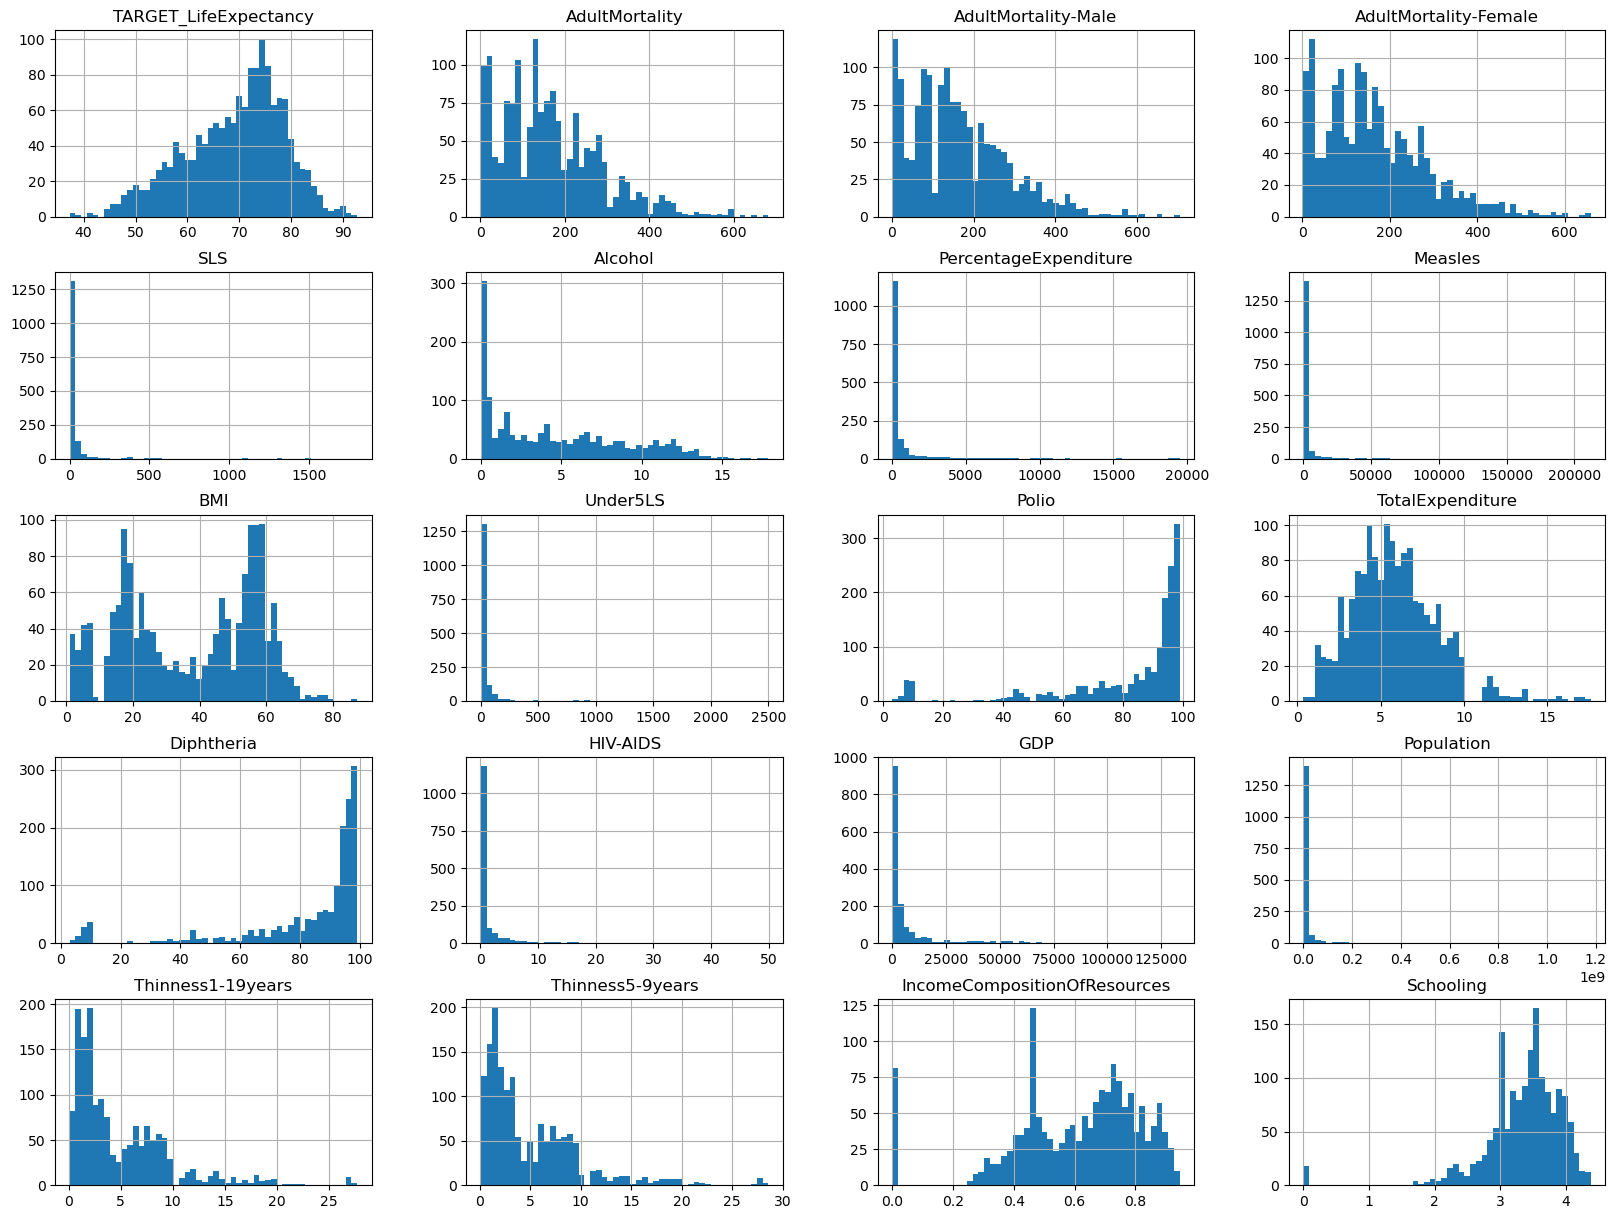

In [14]:
# let see the distribution of all attributes without country, year and status
no_categorical_df = train.drop(['Country', 'Year', 'Status'], axis=1)
no_categorical_df.hist(bins=50, figsize=(20,15))
plt.show()

<span style="font-size:5em;">📝</span> Notes:

What are the benefits of understanding the distributions of the attributes?
- **Selecting Appropriate Models:** Certain models make specific assumptions about the data distribution (e.g., linear regression assumes normally distributed errors). Understanding distributions helps in choosing the most suitable models for our data.
- **Guiding Data Transformation:** Guiding data transformations like normalization or standardization to fit statistical and model requirements.
- **Identifying Data Anomalies:** Spotting outliers or unusual values that could indicate data entry errors, measurement errors, or unique but significant occurrences.
- **Improving Data Quality:** Identifying skewness and kurtosis issues can inform techniques to enhance data quality, such as logarithmic transformations or binning.

It's an essential EDA step!

In [15]:
for col in no_categorical_df.columns:
    stat, p = kstest(no_categorical_df[col], 'norm')
    # print(f'{col} : {stat}, {p}')
    alpha = 0.05
    if p > alpha:
        print(f'{col} is normally distributed')
    else:
        print(f'{col} is not normally distributed')

TARGET_LifeExpectancy is not normally distributed
AdultMortality is not normally distributed
AdultMortality-Male is not normally distributed
AdultMortality-Female is not normally distributed
SLS is not normally distributed
Alcohol is not normally distributed
PercentageExpenditure is not normally distributed
Measles is not normally distributed
BMI is not normally distributed
Under5LS is not normally distributed
Polio is not normally distributed
TotalExpenditure is not normally distributed
Diphtheria is not normally distributed
HIV-AIDS is not normally distributed
GDP is not normally distributed
Population is not normally distributed
Thinness1-19years is not normally distributed
Thinness5-9years is not normally distributed
IncomeCompositionOfResources is not normally distributed
Schooling is not normally distributed


> <span style="font-size:5em;">📝🔍</span> **Observations and Notes:**
> - All attributes are not normally distributed based on K-S test. There are other normality test like shapiro ut shapiro are for sample sizes less than 50 and that's why K-S was considered.
> - Normality of attributes are not necessary for linear and polynomial regression models. The important is the normality of residuals which are the differences between the observed values and the values predicted by the model.

## 4.2 Linearity

In this section, we delve into the exploration of the relationships between variables in our dataset to determine the presence of linear or non-linear patterns. Understanding these relationships is paramount for selecting the most appropriate modeling techniques. Linear relationships suggest the potential effectiveness of linear regression models, whereas non-linear patterns may necessitate more complex approaches, such as decision trees or neural networks. Additionally, we discuss the option of applying linear transformations to non-linear attributes, enabling the use of linear models. This strategic choice significantly influences our machine learning pipeline, guiding us towards methods that best capture the underlying dynamics of our data.

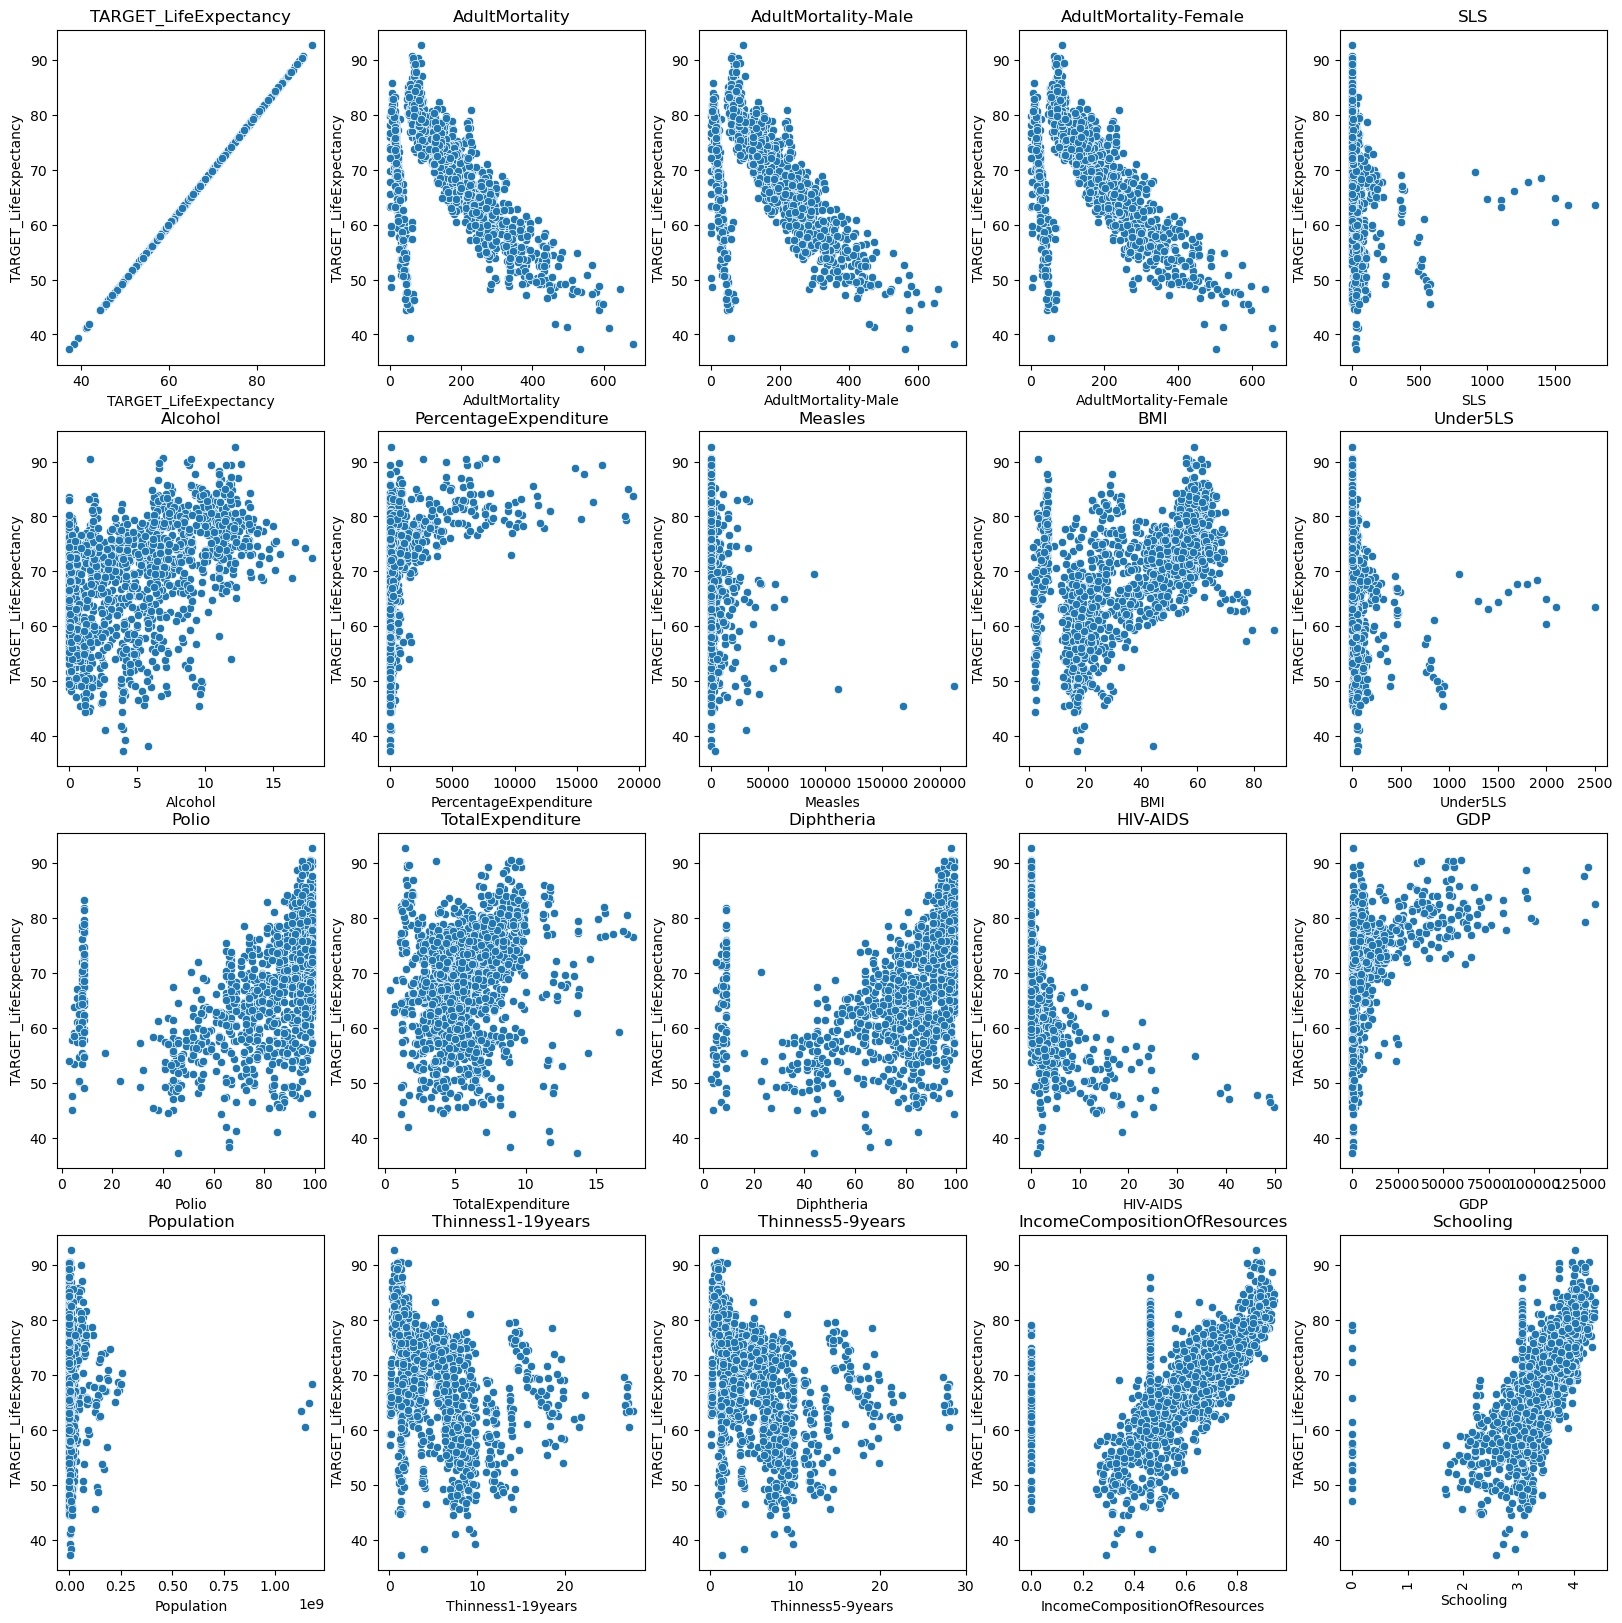

In [16]:
plt.figure(figsize=(20,20))
for i, col in enumerate(no_categorical_df.columns):
    plt.subplot(4,5,i+1)
    sns.scatterplot(data=no_categorical_df, x=col, y='TARGET_LifeExpectancy')
    # sns.regplot(x=col,y='MEDV', data=bostonHouseFrame)
    plt.title(col)


plt.xticks(rotation='vertical')
plt.show()

In [17]:
# let's see the correlation between the attributes
corr_matrix = no_categorical_df.corr()
corr_matrix['TARGET_LifeExpectancy'].sort_values(ascending=False)

TARGET_LifeExpectancy           1.000000
IncomeCompositionOfResources    0.674541
Schooling                       0.634491
BMI                             0.532626
Diphtheria                      0.475711
Polio                           0.445529
Alcohol                         0.435399
GDP                             0.430049
PercentageExpenditure           0.383456
TotalExpenditure                0.237931
Population                     -0.037848
Measles                        -0.172992
SLS                            -0.190341
Under5LS                       -0.213613
Thinness5-9years               -0.422089
Thinness1-19years              -0.427085
HIV-AIDS                       -0.520035
AdultMortality-Female          -0.654367
AdultMortality-Male            -0.656400
AdultMortality                 -0.656732
Name: TARGET_LifeExpectancy, dtype: float64

<span style="font-size:5em;">📝</span> Notes:

The relationship between income and life expectancy is well-documented, showing that life expectancy increases with average income. An analysis revealed that a £1,000 increase in household income is associated with a 3.6-month increase in life expectancy for both men and women. This relationship persists across different measures of income, underscoring the impact of socioeconomic factors on health outcomes. However, it's important to consider other factors such as housing, job quality, and population composition in understanding life expectancy variations​​.

https://www.health.org.uk/evidence-hub/money-and-resources/income/relationship-between-income-and-healthy-life-expectancy-by-neighbourhood

Stanford research has uncovered significant variances in life expectancy linked to income and geography within the United States. The study found that low-income individuals in areas like New York enjoy longer lifespans compared to those in places such as Gary, Indiana, highlighting the profound impact of location and economic status on health outcomes. This research emphasizes the importance of addressing health disparities at the local level, suggesting that policy interventions targeting health behaviors could be particularly effective​​.

https://news.stanford.edu/2016/04/11/geography-income-play-roles-in-life-expectancy-new-stanford-research-shows/

A study exploring the relationship between education levels and life expectancy in Italy, Denmark, and the USA found that increasing education levels are strongly related to rising life expectancy. This relationship underscores the importance of educational policies, especially in newly industrializing countries where education levels are expected to rise significantly. The study suggests that further increases in education levels could lead to continued improvements in life expectancy, highlighting the need for a focus on educational structure changes and their impact on societal health outcomes​​.

https://genus.springeropen.com/articles/10.1186/s41118-019-0055-0

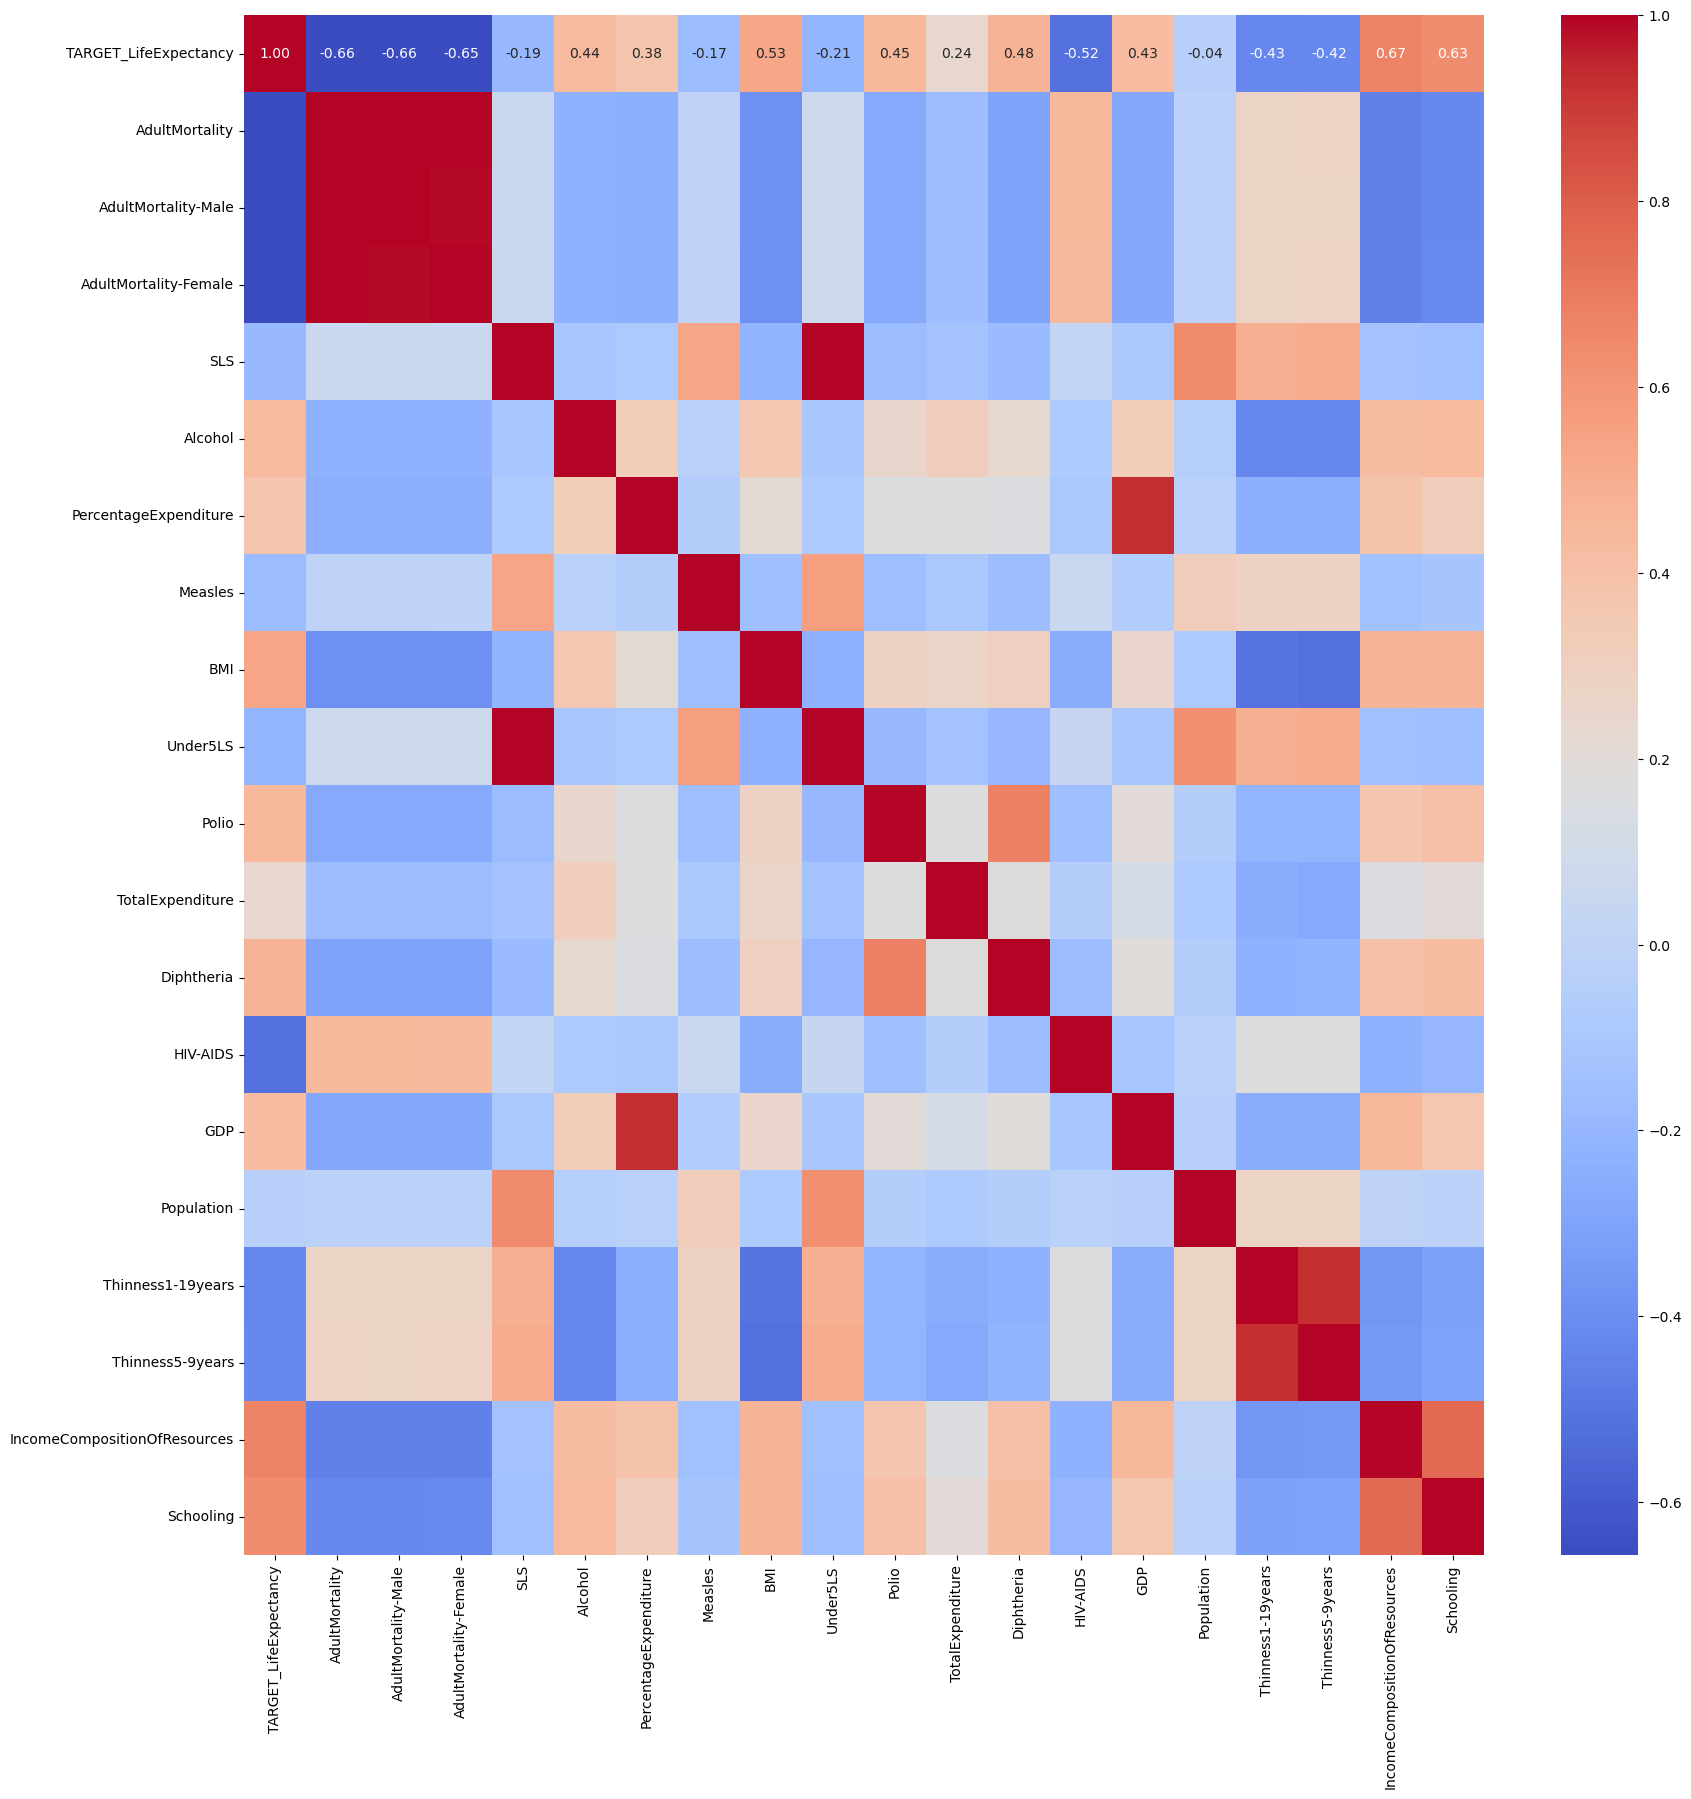

In [18]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

<span style="font-size:5em;">📝</span> Notes:

- In the domain of data analysis, models are tailored to address the nature of relationships between variables. For linear relationships, linear regression models are the tool of choice. On the other hand, decision trees or neural networks are better suited for capturing non-linear dynamics. Alternatively, applying a linear transformation to the data can also enable the use of linear models for non-linear relationships, offering a versatile approach to model selection and optimization.

> <span style="font-size:5em;">🤔</span> **Pending Preprocessing Techniques:**

- For non-linear attributes, transformations such as logarithmic, square root, and Box-Cox transformations can be applied. These techniques can help in stabilizing variance, making the data more normally distributed, and improving the linear relationship between variables, thus enhancing the performance of linear models on non-linear data.

## 4.3 Outliers

In [19]:
# Calculate IQR for each attribute
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1

# Determine outliers for each attribute (True if the value is an outlier, False otherwise)
is_outlier = (train < (Q1 - 1.5 * IQR)) | (train > (Q3 + 1.5 * IQR))

# Calculate the percentage of outliers for each attribute and print the statement
for attribute in train.columns:
    # Calculate percentage
    percentage = np.mean(is_outlier[attribute]) * 100
    # Print statement
    print(f'{attribute}: {percentage:.2f}% outliers')


TARGET_LifeExpectancy: 0.39% outliers
Country: 0.00% outliers
Year: 0.00% outliers
Status: 17.90% outliers
AdultMortality: 1.61% outliers
AdultMortality-Male: 1.35% outliers
AdultMortality-Female: 1.80% outliers
SLS: 9.98% outliers
Alcohol: 0.00% outliers
PercentageExpenditure: 14.04% outliers
Measles: 18.87% outliers
BMI: 0.00% outliers
Under5LS: 11.59% outliers
Polio: 8.31% outliers
TotalExpenditure: 1.74% outliers
Diphtheria: 10.30% outliers
HIV-AIDS: 16.29% outliers
GDP: 14.68% outliers
Population: 14.42% outliers
Thinness1-19years: 3.61% outliers
Thinness5-9years: 3.86% outliers
IncomeCompositionOfResources: 5.22% outliers
Schooling: 2.12% outliers


<span style="font-size:5em;">📝</span> Notes:

At this stage, it remains unclear whether the outliers observed in our dataset stem from measurement errors, data entry mistakes, or are inherent to the distribution itself. It's crucial to note that the removal of outliers is not always the advisable course of action. The process of anomaly detection centers on identifying data points that significantly deviate from the majority of the dataset. Moreover, anomaly detection encompasses a broader scope, aiming to uncover patterns in the data that diverge from anticipated behaviors. This can extend beyond mere outlier detection. Importantly, these outliers may play a pivotal role in influencing trends in life expectancy, either by elevating or diminishing it.

> <span style="font-size:5em;">🤔</span> **Pending Preprocessing Techniques:**

- Outlier ignoring, removal, transofmration, impusting and using robust methods.

# 5. Preprocessing Pipeline

In [20]:
class CustomScaler(BaseEstimator, TransformerMixin):
    """
    A custom scaler that allows for switching between MinMax and Standard scaling methods,
    with the ability to exclude specific attributes from being scaled.

    Parameters:
    - method (str): Specifies the scaling method ('minmax' or 'standard').
    - attributes_to_exclude (list): List of column names to exclude from scaling.
    """
    def __init__(self, method='minmax', attributes_to_exclude=None):
        self.method = method
        self.attributes_to_exclude = attributes_to_exclude if attributes_to_exclude else []
        self.scaler = MinMaxScaler() if method == 'minmax' else StandardScaler()

    def fit(self, X, y=None):
        numerical_attributes = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col]) and col not in self.attributes_to_exclude]
        self.scaler.fit(X[numerical_attributes])
        return self

    def transform(self, X):
        X = X.copy()
        numerical_attributes = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col]) and col not in self.attributes_to_exclude]
        X[numerical_attributes] = self.scaler.transform(X[numerical_attributes])
        return X


class LinearTransformer(BaseEstimator, TransformerMixin):
    """
    Applies a linear transformation to each feature, multiplying by a given factor and adding a constant.
    Specific columns can be excluded from the transformation.

    Parameters:
    - multiplier (float): Factor by which to multiply feature values.
    - addend (float): Constant to add to feature values after multiplication.
    - exclude_columns (list): List of column names to exclude from the transformation.
    """
    def __init__(self, multiplier=1.0, addend=0.0, exclude_columns=None):
        self.multiplier = multiplier
        self.addend = addend
        self.exclude_columns = exclude_columns if exclude_columns is not None else []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in X.columns:
            if column not in self.exclude_columns:
                X_transformed[column] = X_transformed[column] * self.multiplier + self.addend
        return X_transformed


class OutlierRemover(BaseEstimator, TransformerMixin):
    """
    Removes outliers by replacing them with the median or mean of the column based on the specified method.
    This transformer allows specific columns to be excluded from outlier removal.

    Parameters:
    - method (str): Method to use for replacing outliers ('mean' or 'median').
    - attributes_to_exclude (list): List of column names to exclude from outlier removal.
    """
    def __init__(self, method='median', attributes_to_exclude=None):
        self.method = method
        self.attributes_to_exclude = attributes_to_exclude if attributes_to_exclude else []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        numerical_attributes = [col for col in X_transformed.columns if pd.api.types.is_numeric_dtype(X_transformed[col]) and col not in self.attributes_to_exclude]
        for col in numerical_attributes:
            if self.method not in ['mean', 'median']:
                continue
            Q1 = X_transformed[col].quantile(0.25)
            Q3 = X_transformed[col].quantile(0.75)
            IQR = Q3 - Q1
            is_outlier = (X_transformed[col] < (Q1 - 1.5 * IQR)) | (X_transformed[col] > (Q3 + 1.5 * IQR))
            replacement_value = X_transformed[col].median() if self.method == 'median' else X_transformed[col].mean()
            X_transformed.loc[is_outlier, col] = replacement_value
        return X_transformed


class NormalTransformer(BaseEstimator, TransformerMixin):
    """
    Applies a normalizing transformation to numerical features using either log or Box-Cox methods.
    This transformer also allows specific columns to be excluded from the transformation.

    Parameters:
    - method (str): The normalizing method to apply ('log' or 'box-cox').
    - attributes_to_exclude (list): List of column names to exclude from normalization.
    """
    def __init__(self, method='log', attributes_to_exclude=None):
        self.method = method
        self.attributes_to_exclude = attributes_to_exclude if attributes_to_exclude else []
        if method == 'log':
            self.transformer = FunctionTransformer(lambda x: np.log1p(np.clip(x, a_min=0, a_max=None)), validate=False)
        elif method == 'box-cox':
            self.transformer = PowerTransformer(method='box-cox', standardize=True)
        else:
            raise ValueError("Unsupported transformation method")

    def fit(self, X, y=None):
        numerical_attributes = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col]) and col not in self.attributes_to_exclude]
        self.transformer.fit(X[numerical_attributes])
        return self

    def transform(self, X):
        X_transformed = X.copy()
        numerical_attributes = [col for col in X_transformed.columns if pd.api.types.is_numeric_dtype(X_transformed[col]) and col not in self.attributes_to_exclude]
        X_transformed[numerical_attributes] = self.transformer.transform(X_transformed[numerical_attributes])
        return X_transformed

        
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('outlier_removal', OutlierRemover(attributes_to_exclude=['Country', 'Year', 'Status','TARGET_LifeExpectancy'])),
    ('scaling', CustomScaler(attributes_to_exclude=['Country', 'Year', 'Status','TARGET_LifeExpectancy'])),
    ('normal_transformation', NormalTransformer(attributes_to_exclude=['Country', 'Year', 'Status','TARGET_LifeExpectancy'])),
    ('linear_transformation', LinearTransformer(multiplier=2, addend=5,exclude_columns= ['TARGET_LifeExpectancy']))
])

# Apply the preprocessing pipeline to the training and validation sets
train = preprocessing_pipeline.fit_transform(train)
validation = preprocessing_pipeline.fit_transform(validation)

> <span style="font-size:5em;">🔍</span> **Observations:**
>- **Handled Outliers**: Developed a custom transformer `OutlierRemover` that replaces outliers in numerical attributes with the mean value, using the interquartile range to define outliers.
>- **Scaled Numerical Features**: Implemented a `CustomScaler` class, which uses `MinMaxScaler` internally but excludes specified attributes, to scale numerical features to a range between 0 and 1.
>- **Preserved Important Attributes**: Ensured that key attributes such as 'Country', 'Year', 'Status', and the target variable 'TARGET_LifeExpectancy' are not scaled or modified by the transformers.
>- **Constructed a Pipeline**: Assembled a `Pipeline` that sequentially applies missing value removal, outlier replacement, and feature scaling.
>- **Applied the Pipeline**: The `preprocessing_pipeline` was applied to the `train` and `validation` datasets, transforming the data to be ready for model training and evaluation.

# 6. Model

## 6.1 Linear Model

In [21]:
# Preparing the data for training
y_train = train['TARGET_LifeExpectancy']
X_train = train.drop('TARGET_LifeExpectancy', axis=1)
y_validation = validation['TARGET_LifeExpectancy']
X_validation = validation.drop('TARGET_LifeExpectancy', axis=1)

# Initialize the linear regression model
model = LinearRegression()

# Perform 5-fold cross-validation on the training data for R^2 and RMSE
cv_r2_scores_train = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
cv_rmse_scores_train = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

# Calculate the mean and standard deviation of the R^2 scores for the training data
mean_r2_train = np.mean(cv_r2_scores_train)
std_r2_train = np.std(cv_r2_scores_train)

# Calculate the mean RMSE for the training data using the cross-validation results
mean_rmse_train = np.mean(-cv_rmse_scores_train)
std_rmse_train = np.std(-cv_rmse_scores_train)

# Print the cross-validation results for R^2 and RMSE on the training data
print(f'The mean R^2 score for the linear regression model on the training set with 5-fold cross-validation is: {mean_r2_train:.3f}')
print(f'The mean RMSE score for the linear regression model on the training set with 5-fold cross-validation is: {mean_rmse_train:.3f}')

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Evaluate the fitted model on the validation data
r2_score_validation = model.score(X_validation, y_validation)
rmse_score_validation = np.sqrt(mean_squared_error(y_validation, model.predict(X_validation)))

# Print the R^2 and RMSE score for the validation data
print(f'The R^2 score for the linear regression model on the validation set is: {r2_score_validation:.3f}')
print(f'The RMSE score for the linear regression model on the validation set is: {rmse_score_validation:.3f}')

The mean R^2 score for the linear regression model on the training set with 5-fold cross-validation is: 0.699
The mean RMSE score for the linear regression model on the training set with 5-fold cross-validation is: 5.219
The R^2 score for the linear regression model on the validation set is: 0.516
The RMSE score for the linear regression model on the validation set is: 6.500


> <span style="font-size:5em;">🔍</span> **Observations:**
>- Training Performance:
Mean R² on training set: 0.699, indicating a reasonable fit.
Low R² standard deviation (0.008) across folds suggests consistent performance across different training subsets.
>- Training Error:
Mean RMSE: 5.219, with a standard deviation of 0.144, showing stable prediction error across training folds.
Validation Performance:
R² on validation set: 0.516, significantly lower than the training R², hinting at potential overfitting.
>- Validation Error:
RMSE on validation set: 6.500, higher than in training, indicating decreased accuracy on unseen data.
>- These results suggest the model fits the training data well but does not generalize effectively to new data, pointing to overfitting issues.


In [22]:
# predictions
predictions = model.predict(X_validation)

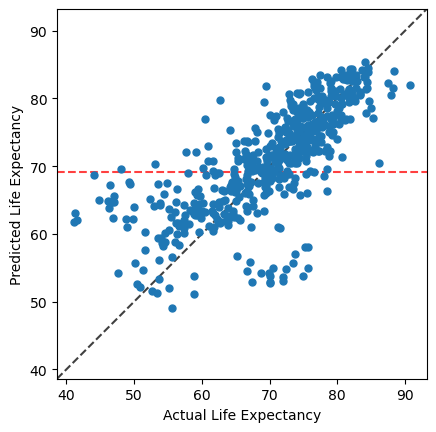

In [23]:
fig, ax = plt.subplots()
ax.scatter(y_validation, predictions, s=25, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.plot(lims, [np.mean(y_train),]*2, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')

plt.show()

> <span style="font-size:5em;">🔍</span> **Observations:**
>- The model outperforms a baseline that predicts the mean; however, there is potential to enhance its performance further. Investigating whether the inclusion of additional terms, such as interaction effects or non-linear transformations, could yield improvements may be worthwhile.

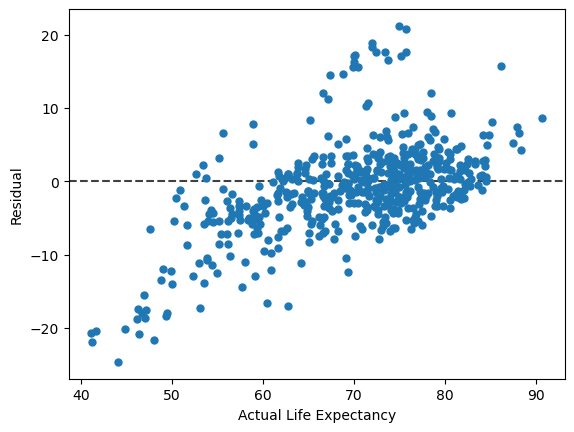

Total distance to all points from the residual at 0 is: 2343.045390287085


In [24]:
# Calculate residuals
residuals = y_validation - predictions

# Calculate the total distance from residuals to 0
total_distance = np.sum(np.abs(residuals))

# Plotting the residuals
fig, ax = plt.subplots()
ax.scatter(y_validation, residuals, s=25, cmap=plt.cm.coolwarm, zorder=10)
xlims = ax.get_xlim()
ax.plot(xlims, [0, 0], 'k--', alpha=0.75, zorder=0)
ax.set_xlim(xlims)
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Residual')

# Display the plot
plt.show()

# Print the total distance
print(f"Total distance to all points from the residual at 0 is: {total_distance}")


> <span style="font-size:5em;">🔍</span> **Observations:**
>- Observations of the residuals reveal persistent patterns; they are not entirely random. Notably, the residuals increase with the house prices, indicating a trend that the model has failed to capture. This suggests potential model limitations in handling higher-value data points.
>- Total distance to all points from the residual at 0 is: 2343.045390287085

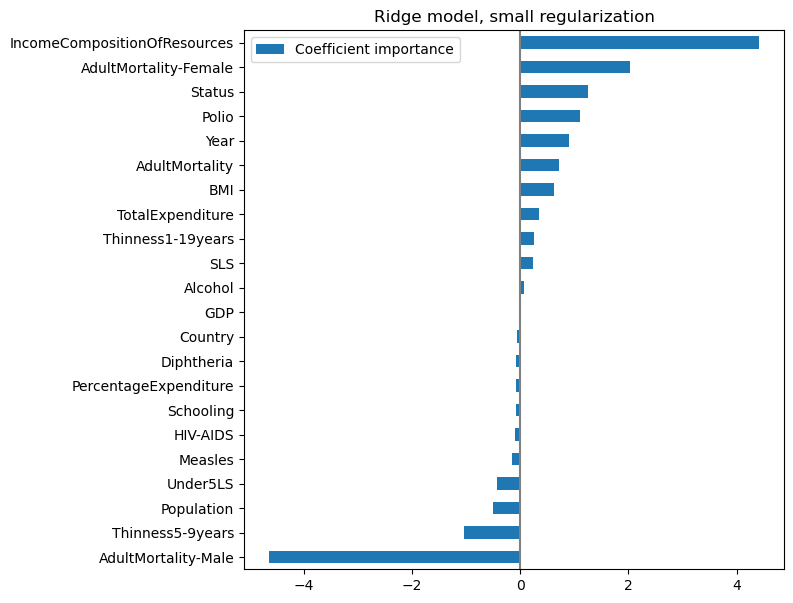

In [25]:
coefs = pd.DataFrame(
    model.coef_  * X_train.std(axis=0),
    columns=['Coefficient importance'], index=X_train.columns
)
coefs.sort_values(by=['Coefficient importance']).plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

> <span style="font-size:5em;">🔍</span> **Observations:**
>- Analysis reveals that the two most critical features are 'IncomeCompositionOfResources' and 'AdultMortality-Male,' indicating their significant impact on the model's predictions.
>- Lets apply regularization and see if the model will perform better.

### 6.1.1 Apply Regularization and Hyperparameter tuning

In [26]:
# Set up the parameters for GridSearchCV
alpha_range = np.logspace(-10, 10, 100)

# Create a Lasso regression object
lasso = Lasso(max_iter=10000)  # Increased max_iter for convergence

# Create a parameter grid for alpha
parameters = {'alpha': alpha_range}

# Set up GridSearchCV with a Lasso estimator, the parameter grid, and R-squared scoring
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)

# Perform GridSearchCV on the training data
lasso_regressor.fit(X_train, y_train)

# Extract the best Lasso model after cross-validation
best_lasso_model = lasso_regressor.best_estimator_

# Calculate R^2 scores for the training set using cross-validation
cv_r2_scores_train = cross_val_score(best_lasso_model, X_train, y_train, cv=5, scoring='r2')

# Calculate the mean R^2 score from cross-validation for the training set
mean_cv_r2_train = cv_r2_scores_train.mean()

# Predict on the training set using the best Lasso model
predicting_X_train = best_lasso_model.predict(X_train)

# Predict on the validation set using the best Lasso model
predicting_X_validation = best_lasso_model.predict(X_validation)

# Calculate the R^2 scores for the training and validation sets
r2_train = r2_score(y_train, predicting_X_train)
r2_validation = r2_score(y_validation, predicting_X_validation)

# Output the results
print('The mean R^2 score from cross-validation on the training set is: {:.3f}'.format(mean_cv_r2_train))
print('The R^2 score for the Lasso Regression model on the training set is: {:.3f}'.format(r2_train))
print('The R^2 score for the Lasso Regression model on the validation set is: {:.3f}'.format(r2_validation))
print('Best alpha parameter found from cross-validation:', lasso_regressor.best_params_['alpha'])


The mean R^2 score from cross-validation on the training set is: 0.701
The R^2 score for the Lasso Regression model on the training set is: 0.706
The R^2 score for the Lasso Regression model on the validation set is: 0.527
Best alpha parameter found from cross-validation: 0.030538555088334123


> <span style="font-size:5em;">🔍</span> **Observations:**
>- After applying regularization, there was no improvement in performance, suggesting the model may be underfitting. This condition implies that the model is too simple to capture the complexity of the data.
>- The negligible difference between training and validation scores, combined with the validation score surpassing the training R², suggests that the model generalizes well to unseen data. However, is there potential to further enhance the score?

## 6.2 Polynomial degree 3: Overfitting

In [27]:
poly = PolynomialFeatures(3)
poly.fit(X_train)
train_X = poly.transform(X_train)
val_X = poly.transform(X_validation)

# Create a linear regression model to use with polynomial features
model = LinearRegression()

# Train the model using the polynomial features
model.fit(train_X, y_train)

# Make predictions on the training and validation set
train_predictions = model.predict(train_X)
validation_predictions = model.predict(val_X)



train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
validation_rmse = np.sqrt(mean_squared_error(y_validation, validation_predictions))

# Using Lasso Regression
lasso_model = Lasso(alpha=1)  # alpha can be tuned further based on validation performance
lasso_model.fit(train_X, y_train)
lasso_train_predictions = lasso_model.predict(train_X)
lasso_validation_predictions = lasso_model.predict(val_X)

print("Lasso Regression:")
print("Training R^2 Score:", r2_score(y_train, lasso_train_predictions))
print("Validation R^2 Score:", r2_score(y_validation, lasso_validation_predictions))
print("Lasso Training RMSE:", np.sqrt(mean_squared_error(y_train, lasso_train_predictions)))
print("Lasso Validation RMSE:", np.sqrt(mean_squared_error(y_validation, lasso_validation_predictions)))


# Optionally print or evaluate predictions
print("Training Predictions:", lasso_train_predictions[:5])  # Show first 5 predictions for brevity
print("Actual Values:", y_train[:5])
print("Validation Predictions:", lasso_validation_predictions[:5])
print("Actual Values:", y_validation[:5])

Lasso Regression:
Training R^2 Score: 0.8213698731610919
Validation R^2 Score: 0.5385195965889304
Lasso Training RMSE: 4.021833097818429
Lasso Validation RMSE: 6.347727683019
Training Predictions: [78.63240363 65.85807264 67.87630082 68.6134379  71.71159297]
Actual Values: ID
1960    80.9
995     60.8
989     66.4
986     62.6
480     77.3
Name: TARGET_LifeExpectancy, dtype: float64
Validation Predictions: [36.39760678 70.45803874 62.72472628 59.95993279 82.18424221]
Actual Values: ID
1692    52.6
1198    73.8
1095    56.6
311     57.4
1767    82.9
Name: TARGET_LifeExpectancy, dtype: float64


> <span style="font-size:5em;">🔍</span> **Observations:**
>- The model is overfitting since Training scores is way less than Validation scores.
>- Can regularization removes overfitting?

In [28]:
# Using Lasso Regression
lasso_model = Lasso(alpha=0.01)  # alpha can be tuned further based on validation performance
lasso_model.fit(train_X, y_train)
lasso_train_predictions = lasso_model.predict(train_X)
lasso_validation_predictions = lasso_model.predict(val_X)

print("Lasso Regression:")
print("Training R^2 Score:", r2_score(y_train, lasso_train_predictions))
print("Validation R^2 Score:", r2_score(y_validation, lasso_validation_predictions))
print("Lasso Training RMSE:", np.sqrt(mean_squared_error(y_train, lasso_train_predictions)))
print("Lasso Validation RMSE:", np.sqrt(mean_squared_error(y_validation, lasso_validation_predictions)))


# Optionally print or evaluate predictions
print("Training Predictions:", lasso_train_predictions[:5])  # Show first 5 predictions for brevity
print("Actual Values:", y_train[:5])
print("Validation Predictions:", lasso_validation_predictions[:5])
print("Actual Values:", y_validation[:5])

Lasso Regression:
Training R^2 Score: 0.8531184787542352
Validation R^2 Score: 0.4571954582486084
Lasso Training RMSE: 3.6469538822694285
Lasso Validation RMSE: 6.884357136049237
Training Predictions: [78.02711651 66.2484772  66.22945278 67.60103223 74.69337297]
Actual Values: ID
1960    80.9
995     60.8
989     66.4
986     62.6
480     77.3
Name: TARGET_LifeExpectancy, dtype: float64
Validation Predictions: [29.18718926 70.2848061  63.90501286 56.37547513 82.99870172]
Actual Values: ID
1692    52.6
1198    73.8
1095    56.6
311     57.4
1767    82.9
Name: TARGET_LifeExpectancy, dtype: float64


> <span style="font-size:5em;">🔍</span> **Observations:**
>- Regularization did not remove overfitting and hence the model is not suitable.

## 6.3 Polynomial degree 2

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n + \beta_{n+1} x_1^2 + \beta_{n+2} x_2^2 + \ldots + \beta_{2n} x_n^2 + \beta_{2n+1} x_1 x_2 + \ldots + \beta_{\frac{n(n-1)}{2}+2n} x_{n-1} x_n
$$


In [29]:
poly = PolynomialFeatures(2)
poly.fit(X_train)
train_X = poly.transform(X_train)
val_X = poly.transform(X_validation)

# Create a linear regression model to use with polynomial features
model = LinearRegression()

# Train the model using the polynomial features
model.fit(train_X, y_train)

# Make predictions on the training and validation set
train_predictions = model.predict(train_X)
validation_predictions = model.predict(val_X)



train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
validation_rmse = np.sqrt(mean_squared_error(y_validation, validation_predictions))

# Optionally print or evaluate predictions
print("Training Predictions:", train_predictions[:5])  # Show first 5 predictions for brevity
print("Actual Values:", y_train[:5])
print("Validation Predictions:", validation_predictions[:5])
print("Actual Values:", y_validation[:5])

# Evaluate the model performance
from sklearn.metrics import r2_score
print("Training R^2 Score:", r2_score(y_train, train_predictions))
print("Validation R^2 Score:", r2_score(y_validation, validation_predictions))
print("Training RMSE:", train_rmse)
print("Validation RMSE:", validation_rmse)

Training Predictions: [81.83551508 65.60720093 65.66825761 66.19347666 73.58835972]
Actual Values: ID
1960    80.9
995     60.8
989     66.4
986     62.6
480     77.3
Name: TARGET_LifeExpectancy, dtype: float64
Validation Predictions: [-62.11590931  26.41742117 -83.05053732  15.22071272  28.97841001]
Actual Values: ID
1692    52.6
1198    73.8
1095    56.6
311     57.4
1767    82.9
Name: TARGET_LifeExpectancy, dtype: float64
Training R^2 Score: 0.8837123408228466
Validation R^2 Score: -504.9070137474911
Training RMSE: 3.2449910607493635
Validation RMSE: 210.173039828097


> <span style="font-size:5em;">🔍</span> **Observations:**
>- The model continues to overfit. Introducing regularization could potentially mitigate this overfitting.

### 6.3.1 Regularization of Polynomial degree 2

In [30]:
# Using Lasso Regression
lasso_model = Lasso(alpha=1)  # alpha can be tuned further based on validation performance
lasso_model.fit(train_X, y_train)
lasso_train_predictions = lasso_model.predict(train_X)
lasso_validation_predictions = lasso_model.predict(val_X)

print("Lasso Regression:")
print("Training R^2 Score:", r2_score(y_train, lasso_train_predictions))
print("Validation R^2 Score:", r2_score(y_validation, lasso_validation_predictions))
print("Lasso Training RMSE:", np.sqrt(mean_squared_error(y_train, lasso_train_predictions)))
print("Lasso Validation RMSE:", np.sqrt(mean_squared_error(y_validation, lasso_validation_predictions)))


# Optionally print or evaluate predictions
print("Training Predictions:", lasso_train_predictions[:5])  # Show first 5 predictions for brevity
print("Actual Values:", y_train[:5])
print("Validation Predictions:", lasso_validation_predictions[:5])
print("Actual Values:", y_validation[:5])


Lasso Regression:
Training R^2 Score: 0.7208716726413777
Validation R^2 Score: 0.5077142409810873
Lasso Training RMSE: 5.027460268499793
Lasso Validation RMSE: 6.556171291665068
Training Predictions: [74.21914287 65.23689082 70.11897777 70.48781275 70.55861129]
Actual Values: ID
1960    80.9
995     60.8
989     66.4
986     62.6
480     77.3
Name: TARGET_LifeExpectancy, dtype: float64
Validation Predictions: [48.49626283 67.45913287 61.3874961  60.78225082 83.47835397]
Actual Values: ID
1692    52.6
1198    73.8
1095    56.6
311     57.4
1767    82.9
Name: TARGET_LifeExpectancy, dtype: float64


> <span style="font-size:5em;">🔍</span> **Observations:**
>- The training and validation scores are closely aligned but low accuracy. However, there may still be room for improvement. Could hyperparameter tuning further enhance the model's performance?

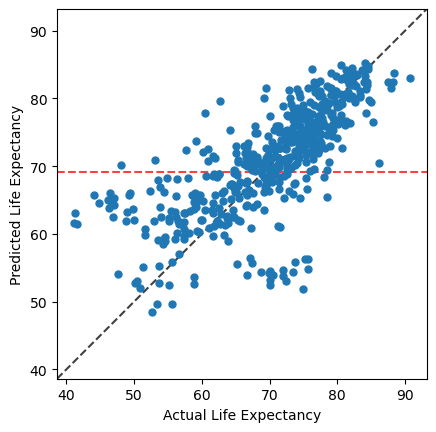

In [31]:
fig, ax = plt.subplots()
ax.scatter(y_validation, lasso_validation_predictions, s=25, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.plot(lims, [np.mean(y_train),]*2, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')

plt.show()

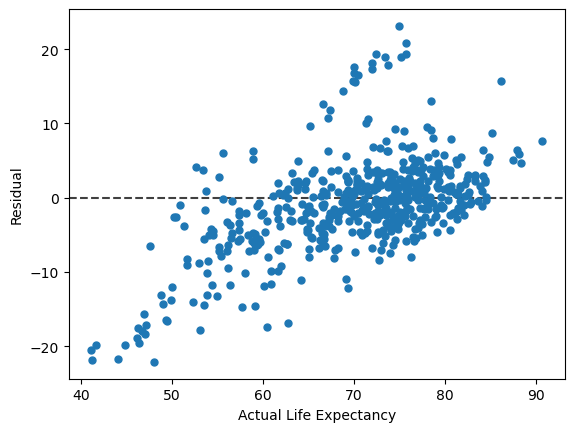

Total distance to all points from the residual at 0 is: 2364.471723109236


In [32]:
# Calculate residuals
residuals = y_validation - lasso_validation_predictions

# Calculate the total distance from residuals to 0
total_distance = np.sum(np.abs(residuals))

# Plotting the residuals
fig, ax = plt.subplots()
ax.scatter(y_validation, residuals, s=25, cmap=plt.cm.coolwarm, zorder=10)
xlims = ax.get_xlim()
ax.plot(xlims, [0, 0], 'k--', alpha=0.75, zorder=0)
ax.set_xlim(xlims)
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Residual')

# Display the plot
plt.show()

# Print the total distance
print(f"Total distance to all points from the residual at 0 is: {total_distance}")


> <span style="font-size:5em;">🔍</span> **Observations:**
>- We can see there's an upward trend.
>- The model is not doing better than the linear model.

In [33]:
y_validation.describe()

count    518.000000
mean      69.896139
std        9.353222
min       41.100000
25%       64.600000
50%       72.000000
75%       76.475000
max       90.700000
Name: TARGET_LifeExpectancy, dtype: float64

### 6.3.2 Hyperparameter tuning

<span style="font-size:5em;">📝</span> Notes:
- Very high lambda/alpha, will make coefficients approaches 0 for Ridge and Lesso. This is because to reduce the total cost effectively, the model must reduce the magnitude of the cost term (ridge/lesso regularization), which will make coefficients small since lambda/alpha is high.
- The difference between Lasso and Ridge is that both penalize feature and make them approach zeros but Lasso actually feature selection and remove some features completely by making their coefficients zeros.
- Increasing the value of lambda/alpha for lasso means that feature selection will be more rough. 

In [34]:
# Define the pipeline with preprocessing steps and the Lasso regressor
pipeline = Pipeline([
    ('outlier_removal', OutlierRemover(attributes_to_exclude=['Country', 'Year', 'Status', 'TARGET_LifeExpectancy'])),
    ('scaling', CustomScaler(attributes_to_exclude=['Country', 'Year', 'Status', 'TARGET_LifeExpectancy'])),
    ('normal_transformation', NormalTransformer(attributes_to_exclude=['Country', 'Year', 'Status', 'TARGET_LifeExpectancy'])),
    ('linear_transformation', LinearTransformer(exclude_columns=['TARGET_LifeExpectancy'])),
    ('lasso', Lasso())
])

# Define the parameter grid
param_grid = {
    'outlier_removal__method': ['mean', 'median'],
    'scaling__method': ['standard', 'minmax'],
    'normal_transformation__method': ['log', 'box-cox'],
    'linear_transformation__multiplier': [1, 2, 3],
    'linear_transformation__addend': [0, 5, 10],
    'lasso__alpha': np.logspace(-4, 4, 10)
}


# Splitting the training dataset
y_train_hyperparameter = train_hyperparameter['TARGET_LifeExpectancy']
X_train_hyperparameter = train_hyperparameter.drop('TARGET_LifeExpectancy', axis=1)

# Splitting the validation dataset
y_validation_hyperparameter = validation_hyperparameter['TARGET_LifeExpectancy']
X_validation_hyperparameter = validation_hyperparameter.drop('TARGET_LifeExpectancy', axis=1)

# Setup GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_hyperparameter, y_train_hyperparameter)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'lasso__alpha': 0.046415888336127774, 'linear_transformation__addend': 0, 'linear_transformation__multiplier': 3, 'normal_transformation__method': 'log', 'outlier_removal__method': 'mean', 'scaling__method': 'standard'}


In [35]:
# Define the pipeline with the selected hyperparameters
pipeline = Pipeline([
    ('outlier_removal', OutlierRemover(method='mean', attributes_to_exclude=['Country', 'Year', 'Status', 'TARGET_LifeExpectancy'])),
    ('scaling', CustomScaler(method='standard', attributes_to_exclude=['Country', 'Year', 'Status', 'TARGET_LifeExpectancy'])),
    ('normal_transformation', NormalTransformer(method='log', attributes_to_exclude=['Country', 'Year', 'Status', 'TARGET_LifeExpectancy'])),
    ('linear_transformation', LinearTransformer(multiplier=3, addend=0, exclude_columns=['TARGET_LifeExpectancy'])),
    ('lasso', Lasso(alpha=0.046415888336127774))
])

# Define a scorer for RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Perform cross-validation on the training data
r2_scores_train = cross_val_score(pipeline, X_train_hyperparameter, y_train_hyperparameter, cv=5, scoring='r2')
rmse_scores_train = cross_val_score(pipeline, X_train_hyperparameter, y_train_hyperparameter, cv=5, scoring=rmse_scorer)

# Print cross-validation results for training data
mean_r2_train = np.mean(r2_scores_train)
std_r2_train = np.std(r2_scores_train)
mean_rmse_train = -np.mean(rmse_scores_train)  # Negate to correct the sign for RMSE
std_rmse_train = np.std(rmse_scores_train)

print(f"Training - Mean R-squared: {mean_r2_train:.3f}")
print(f"Training - Mean RMSE: {mean_rmse_train:.3f}")

# Fit the model on the entire training data and predict on validation data
pipeline.fit(X_train_hyperparameter, y_train_hyperparameter)
y_pred_validation = pipeline.predict(X_validation_hyperparameter)

# Calculate R-squared and RMSE for validation data
r2_validation = r2_score(y_validation_hyperparameter, y_pred_validation)
rmse_validation = np.sqrt(mean_squared_error(y_validation_hyperparameter, y_pred_validation))

print(f"Validation - R-squared: {r2_validation:.3f}")
print(f"Validation - RMSE: {rmse_validation:.3f}")

Training - Mean R-squared: 0.753
Training - Mean RMSE: 4.724
Validation - R-squared: 0.743
Validation - RMSE: 4.733


> <span style="font-size:5em;">🔍</span> **Observations:**
>- Best parameters: {'lasso__alpha': 0.046415888336127774, 'linear_transformation__addend': 0, 'linear_transformation__multiplier': 3, 'normal_transformation__method': 'log', 'outlier_removal__method': 'mean', 'scaling__method': 'standard'}
>- Hyperparameter tuning enhanced the model's performance on the validation set by 0.02 percent. The improvement is not significant and this is because 
>- To further improve the model, it is essential to capture non-linear relationships within the data.

# 7. Summary and Future Improvements

In our evaluation of polynomial models, we found that models with degrees higher than 2 tended to overfit, capturing noise along with underlying data patterns due to their high variance. Conversely, models with degrees less than 2 underfit, unable to delineate the essential patterns of the dataset due to their high bias. The degree 2 polynomial model struck an optimal balance, effectively capturing significant patterns without succumbing to the noise, indicating a suitable compromise between bias and variance.

To further refine and enhance our model's accuracy, exploring a broader range of hyperparameters through grid or random search could be beneficial. Considering non-linear models such as decision trees, random forests, or support vector machines might address the complexities of the data more effectively. Additionally, employing neural networks or ensemble methods could potentially capture more sophisticated data patterns. Regularization techniques and advanced feature engineering may also help mitigate overfitting and improve the model's ability to generalize to unseen data, ensuring robust performance across diverse datasets.

# 8. Test Predictions

In [36]:
test_predictions = pipeline.predict(test)

In [37]:
len(test)

867

In [38]:
len(test_predictions)

867

In [40]:
# lets save the test_predictions to a csv file
test['TARGET_LifeExpectancy'] = test_predictions
test[['TARGET_LifeExpectancy']].to_csv('submission.csv')